# Modèles et prédictions

In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
import lightgbm as lgb
import time
import copy
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, classification_report, confusion_matrix


from ncaam.src.dao.loader import Loader

In [2]:
loader = Loader()
data = loader.import_data(["MNCAATourneySeeds", "MNCAATourneyCompactResults", "MRegularSeasonCompactResults"])

### Helper functions and classes

In [3]:
class LGBWrapper(object):
    """
    A wrapper for lightgbm model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = lgb.LGBMClassifier()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):

        eval_set = [(X_train, y_train)]
        eval_names = ['train']
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('valid')

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = 'auto'
        else:
            categorical_columns = 'auto'

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_names=eval_names,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'])

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict_proba(self, X_test):
        if self.model.objective == 'binary':
            return self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)[:, 1]
        else:
            return self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)

In [4]:
class MainTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, convert_cyclical: bool = False, create_interactions: bool = False, n_interactions: int = 20):
        """
        Main transformer for the data. Can be used for processing on the whole data.

        :param convert_cyclical: convert cyclical features into continuous
        :param create_interactions: create interactions between features
        """

        self.convert_cyclical = convert_cyclical
        self.create_interactions = create_interactions
        self.feats_for_interaction = None
        self.n_interactions = n_interactions

    def fit(self, X, y=None):

        if self.create_interactions:
            pass
        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)

        # data['installation_event_code_count_mean'] = data.groupby(['installation_id'])['sum_event_code_count'].transform('mean')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)


class FeatureTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, main_cat_features: list = None, num_cols: list = None):
        """

        :param main_cat_features:
        :param num_cols:
        """
        self.main_cat_features = main_cat_features
        self.num_cols = num_cols

    def fit(self, X, y=None):

        self.num_cols = [col for col in X.columns if 'sum' in col or 'mean' in col or 'max' in col or 'std' in col
                         or 'attempt' in col]

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
#         for col in self.num_cols:
#             data[f'{col}_to_mean'] = data[col] / data.groupby('installation_id')[col].transform('mean')
#             data[f'{col}_to_std'] = data[col] / data.groupby('installation_id')[col].transform('std')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)

In [5]:
class ClassifierModel(object):
    """
    A wrapper class for classification models.
    It can be used for training and prediction.
    Can plot feature importance and training progress (if relevant for model).

    """

    def __init__(self, columns: list = None, model_wrapper=None):
        """

        :param original_columns:
        :param model_wrapper:
        """
        self.columns = columns
        self.model_wrapper = model_wrapper
        self.result_dict = {}
        self.train_one_fold = False
        self.preprocesser = None

    def fit(self, X: pd.DataFrame, y,
            X_holdout: pd.DataFrame = None, y_holdout=None,
            folds=None,
            params: dict = None,
            eval_metric='auc',
            cols_to_drop: list = None,
            preprocesser=None,
            transformers: dict = None,
            adversarial: bool = False,
            plot: bool = True):
        """
        Training the model.

        :param X: training data
        :param y: training target
        :param X_holdout: holdout data
        :param y_holdout: holdout target
        :param folds: folds to split the data. If not defined, then model will be trained on the whole X
        :param params: training parameters
        :param eval_metric: metric for validataion
        :param cols_to_drop: list of columns to drop (for example ID)
        :param preprocesser: preprocesser class
        :param transformers: transformer to use on folds
        :param adversarial
        :return:
        """
        self.cols_to_drop = cols_to_drop

        if folds is None:
            folds = KFold(n_splits=3, random_state=42)
            self.train_one_fold = True

        self.columns = X.columns if self.columns is None else self.columns
        self.feature_importances = pd.DataFrame(columns=['feature', 'importance'])
        self.trained_transformers = {k: [] for k in transformers}
        self.transformers = transformers
        self.models = []
        self.folds_dict = {}
        self.eval_metric = eval_metric
        n_target = 1 if len(set(y.values)) == 2 else len(set(y.values))
        self.oof = np.zeros((len(X), n_target))
        self.n_target = n_target

        X = X[self.columns]
        if X_holdout is not None:
            X_holdout = X_holdout[self.columns]

        if preprocesser is not None:
            self.preprocesser = preprocesser
            self.preprocesser.fit(X, y)
            X = self.preprocesser.transform(X, y)
            self.columns = X.columns.tolist()
            if X_holdout is not None:
                X_holdout = self.preprocesser.transform(X_holdout)
            # y = X['accuracy_group']

        for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
            if X_holdout is not None:
                X_hold = X_holdout.copy()
            else:
                X_hold = None
            self.folds_dict[fold_n] = {}
            if params['verbose']:
                print(f'Fold {fold_n + 1} started at {time.ctime()}')
            self.folds_dict[fold_n] = {}

            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            if self.train_one_fold:
                X_train = X[self.original_columns]
                y_train = y
                X_valid = None
                y_valid = None

            datasets = {'X_train': X_train, 'X_valid': X_valid, 'X_holdout': X_hold, 'y_train': y_train}
            X_train, X_valid, X_hold = self.transform_(datasets, cols_to_drop)

            self.folds_dict[fold_n]['columns'] = X_train.columns.tolist()

            model = copy.deepcopy(self.model_wrapper)

            if adversarial:
                X_new1 = X_train.copy()
                if X_valid is not None:
                    X_new2 = X_valid.copy()
                elif X_holdout is not None:
                    X_new2 = X_holdout.copy()
                X_new = pd.concat([X_new1, X_new2], axis=0)
                y_new = np.hstack((np.zeros((X_new1.shape[0])), np.ones((X_new2.shape[0]))))
                X_train, X_valid, y_train, y_valid = train_test_split(X_new, y_new)

            model.fit(X_train, y_train, X_valid, y_valid, X_hold, y_holdout, params=params)

            self.folds_dict[fold_n]['scores'] = model.best_score_
            if self.oof.shape[0] != len(X):
                self.oof = np.zeros((X.shape[0], self.oof.shape[1]))
            if not adversarial:
                self.oof[valid_index] = model.predict_proba(X_valid).reshape(-1, n_target)

            fold_importance = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)),
                                           columns=['feature', 'importance'])
            self.feature_importances = self.feature_importances.append(fold_importance)
            self.models.append(model)

        self.feature_importances['importance'] = self.feature_importances['importance'].astype(float)

        # if params['verbose']:
        self.calc_scores_()

        if plot:
#             print(classification_report(y, self.oof.argmax(1)))
            print(classification_report(y, (self.oof > 0.5) * 1))
            fig, ax = plt.subplots(figsize=(16, 12))
            plt.subplot(2, 2, 1)
            self.plot_feature_importance(top_n=25)
            plt.subplot(2, 2, 2)
            self.plot_metric()
            plt.subplot(2, 2, 3)
            g = sns.heatmap(confusion_matrix(y, (self.oof > 0.5) * 1), annot=True, cmap=plt.cm.Blues,fmt="d")
            g.set(ylim=(-0.5, 4), xlim=(-0.5, 4), title='Confusion matrix')

            plt.subplot(2, 2, 4)
            plt.hist(self.oof)
            plt.xticks(range(self.n_target), range(self.n_target))
            plt.title('Distribution of oof predictions');

    def transform_(self, datasets, cols_to_drop):
        for name, transformer in self.transformers.items():
            transformer.fit(datasets['X_train'], datasets['y_train'])
            datasets['X_train'] = transformer.transform(datasets['X_train'])
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = transformer.transform(datasets['X_valid'])
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = transformer.transform(datasets['X_holdout'])
            self.trained_transformers[name].append(transformer)
        if cols_to_drop is not None:
            cols_to_drop = [col for col in cols_to_drop if col in datasets['X_train'].columns]
            self.cols_to_drop = cols_to_drop
            datasets['X_train'] = datasets['X_train'].drop(cols_to_drop, axis=1)
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = datasets['X_valid'].drop(cols_to_drop, axis=1)
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = datasets['X_holdout'].drop(cols_to_drop, axis=1)

        return datasets['X_train'], datasets['X_valid'], datasets['X_holdout']

    def calc_scores_(self):
        print()
        datasets = [k for k, v in [v['scores'] for k, v in self.folds_dict.items()][0].items() if len(v) > 0]
        self.scores = {}
        for d in datasets:
            scores = [v['scores'][d][self.eval_metric] for k, v in self.folds_dict.items()]
            print(f"CV mean score on {d}: {np.mean(scores):.4f} +/- {np.std(scores):.4f} std.")
            self.scores[d] = np.mean(scores)

    def predict(self, X_test, averaging: str = 'usual'):
        """
        Make prediction

        :param X_test:
        :param averaging: method of averaging
        :return:
        """
        full_prediction = np.zeros((X_test.shape[0], self.oof.shape[1]))
        if self.preprocesser is not None:
            X_test = self.preprocesser.transform(X_test)
        for i in range(len(self.models)):
            X_t = X_test.copy()
            for name, transformers in self.trained_transformers.items():
                X_t = transformers[i].transform(X_t)
            if self.cols_to_drop:
                cols_to_drop = [col for col in self.cols_to_drop if col in X_t.columns]
                X_t = X_t.drop(cols_to_drop, axis=1)
            y_pred = self.models[i].predict_proba(X_t[self.folds_dict[i]['columns']]).reshape(-1, full_prediction.shape[1])

            # if case transformation changes the number of the rows
            if full_prediction.shape[0] != len(y_pred):
                full_prediction = np.zeros((y_pred.shape[0], self.oof.shape[1]))

            if averaging == 'usual':
                full_prediction += y_pred
            elif averaging == 'rank':
                full_prediction += pd.Series(y_pred).rank().values

        return full_prediction / len(self.models)

    def plot_feature_importance(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Plot default feature importance.

        :param drop_null_importance: drop columns with null feature importance
        :param top_n: show top n columns
        :return:
        """

        top_feats = self.get_top_features(drop_null_importance, top_n)
        feature_importances = self.feature_importances.loc[self.feature_importances['feature'].isin(top_feats)]
        feature_importances['feature'] = feature_importances['feature'].astype(str)
        top_feats = [str(i) for i in top_feats]
        sns.barplot(data=feature_importances, x='importance', y='feature', orient='h', order=top_feats)
        plt.title('Feature importances')

    def get_top_features(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Get top features by importance.

        :param drop_null_importance:
        :param top_n:
        :return:
        """
        grouped_feats = self.feature_importances.groupby(['feature'])['importance'].mean()
        if drop_null_importance:
            grouped_feats = grouped_feats[grouped_feats != 0]
        return list(grouped_feats.sort_values(ascending=False).index)[:top_n]

    def plot_metric(self):
        """
        Plot training progress.
        Inspired by `plot_metric` from https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/plotting.html

        :return:
        """
        full_evals_results = pd.DataFrame()
        for model in self.models:
            evals_result = pd.DataFrame()
            for k in model.model.evals_result_.keys():
                evals_result[k] = model.model.evals_result_[k][self.eval_metric]
            evals_result = evals_result.reset_index().rename(columns={'index': 'iteration'})
            full_evals_results = full_evals_results.append(evals_result)

        full_evals_results = full_evals_results.melt(id_vars=['iteration']).rename(columns={'value': self.eval_metric,
                                                                                            'variable': 'dataset'})
        full_evals_results[self.eval_metric] = np.abs(full_evals_results[self.eval_metric])
        sns.lineplot(data=full_evals_results, x='iteration', y=self.eval_metric, hue='dataset')
        plt.title('Training progress')

In [6]:
MNCAATourneySeeds = data["MNCAATourneySeeds"]
MNCAATourneySeeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [7]:
MNCAATourneyCompactResults = data["MNCAATourneyCompactResults"]
MNCAATourneyCompactResults.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [8]:
MRegularSeasonCompactResults = data["MRegularSeasonCompactResults"]
MRegularSeasonCompactResults.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


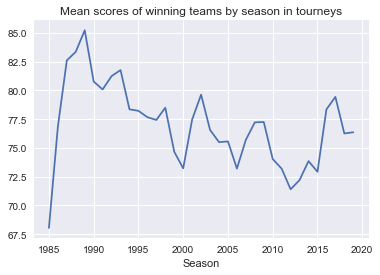

In [9]:
MNCAATourneyCompactResults.groupby(['Season'])['WScore'].mean().plot(kind='line');
plt.title('Mean scores of winning teams by season in tourneys');

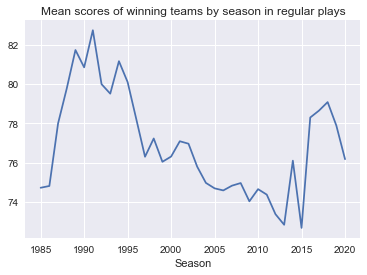

In [10]:
MRegularSeasonCompactResults.groupby(['Season'])['WScore'].mean().plot();
plt.title('Mean scores of winning teams by season in regular plays');

### Data processing and feature engineering

In [11]:
# process seed
MNCAATourneySeeds = MNCAATourneySeeds.loc[MNCAATourneySeeds['Season'] <= 2014]
MNCAATourneySeeds['Seed'] = MNCAATourneySeeds['Seed'].apply(lambda x: int(x[1:3]))

# take only useful columns
MNCAATourneySeeds = MNCAATourneySeeds[['Season', 'TeamID', 'Seed']]
MNCAATourneyCompactResults = MNCAATourneyCompactResults[['Season','WTeamID', 'LTeamID']]
MNCAATourneyCompactResults = MNCAATourneyCompactResults.loc[MNCAATourneyCompactResults['Season'] <= 2014]

# merge the data and rename the columns
df = pd.merge(MNCAATourneyCompactResults, MNCAATourneySeeds,
              how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'])
df = pd.merge(df, MNCAATourneySeeds, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'])
df = df.drop(['TeamID_x', 'TeamID_y'], axis=1)
df.columns = ['Season', 'WTeamID', 'LTeamID', 'WSeed', 'LSeed']
df.head()

/Users/nicolasrousseau/pycharm_projects/ncaam-2020/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Season,WTeamID,LTeamID,WSeed,LSeed
0,1985,1116,1234,9,8
1,1985,1120,1345,11,6
2,1985,1207,1250,1,16
3,1985,1229,1425,9,8
4,1985,1242,1325,3,14


In [12]:
team_win_score = MRegularSeasonCompactResults.groupby(['Season', 'WTeamID']).agg({'WScore':['sum', 'count']}).reset_index()
team_win_score.columns = ['Season', 'WTeamID', 'WScore_sum', 'WScore_count']

team_loss_score = MRegularSeasonCompactResults.groupby(['Season', 'LTeamID']).agg({'LScore':['sum', 'count']}).reset_index()
team_loss_score.columns = ['Season', 'LTeamID', 'LScore_sum', 'LScore_count']

df = pd.merge(df, team_win_score, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'WTeamID'])
df = pd.merge(df, team_loss_score, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'LTeamID'])
df = pd.merge(df, team_loss_score, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'LTeamID'])
df = pd.merge(df, team_win_score, how='left', left_on=['Season', 'LTeamID_x'], right_on=['Season', 'WTeamID'])

df.drop(['LTeamID_y', 'WTeamID_y'], axis=1, inplace=True)
df.head()

,Season,WTeamID_x,LTeamID_x,WSeed,LSeed,WScore_sum_x,WScore_count_x,LScore_sum_x,LScore_count_x,LScore_sum_y,LScore_count_y,WScore_sum_y,WScore_count_y
0,1985,1116,1234,9,8,1448,21,567.0,10.0,708.0,12.0,1525,20
1,1985,1120,1345,11,6,1308,18,537.0,8.0,732.0,11.0,1191,17
2,1985,1207,1250,1,16,1917,25,1085.0,18.0,128.0,2.0,822,11
3,1985,1229,1425,9,8,1484,20,529.0,9.0,449.0,7.0,1386,19
4,1985,1242,1325,3,14,1809,23,475.0,7.0,472.0,7.0,1349,20


In [13]:
df['x_score'] = df['WScore_sum_x'] + df['LScore_sum_y']
df['y_score'] = df['WScore_sum_y'] + df['LScore_sum_x']
df['x_count'] = df['WScore_count_x'] + df['LScore_count_y']
df['y_count'] = df['WScore_count_y'] + df['LScore_count_x']

df.head()

,Season,WTeamID_x,LTeamID_x,WSeed,LSeed,WScore_sum_x,WScore_count_x,LScore_sum_x,LScore_count_x,LScore_sum_y,LScore_count_y,WScore_sum_y,WScore_count_y,x_score,y_score,x_count,y_count
0,1985,1116,1234,9,8,1448,21,567.0,10.0,708.0,12.0,1525,20,2156.0,2092.0,33.0,30.0
1,1985,1120,1345,11,6,1308,18,537.0,8.0,732.0,11.0,1191,17,2040.0,1728.0,29.0,25.0
2,1985,1207,1250,1,16,1917,25,1085.0,18.0,128.0,2.0,822,11,2045.0,1907.0,27.0,29.0
3,1985,1229,1425,9,8,1484,20,529.0,9.0,449.0,7.0,1386,19,1933.0,1915.0,27.0,28.0
4,1985,1242,1325,3,14,1809,23,475.0,7.0,472.0,7.0,1349,20,2281.0,1824.0,30.0,27.0


In [14]:
df_win = df.copy()
df_los = df.copy()
df_win = df_win[['WSeed', 'LSeed', 'x_score', 'y_score', 'x_count', 'y_count']]
df_los = df_los[['LSeed', 'WSeed', 'y_score', 'x_score', 'y_count', 'x_count']]
df_win.columns = ['Seed_1', 'Seed_2', 'Score_1', 'Score_2', 'Count_1', 'Count_2']
df_los.columns = ['Seed_1', 'Seed_2', 'Score_1', 'Score_2', 'Count_1', 'Count_2']

In [15]:
df_win['Seed_diff'] = df_win['Seed_1'] - df_win['Seed_2']
df_win['Score_diff'] = df_win['Score_1'] - df_win['Score_2']
df_los['Seed_diff'] = df_los['Seed_1'] - df_los['Seed_2']
df_los['Score_diff'] = df_los['Score_1'] - df_los['Score_2']

df_win['Count_diff'] = df_win['Count_1'] - df_win['Count_2']
df_win['Mean_score1'] = df_win['Score_1'] / df_win['Count_1']
df_win['Mean_score2'] = df_win['Score_2'] / df_win['Count_2']
df_win['Mean_score_diff'] = df_win['Mean_score1'] - df_win['Mean_score2']
df_los['Count_diff'] = df_los['Count_1'] - df_los['Count_2']
df_los['Mean_score1'] = df_los['Score_1'] / df_los['Count_1']
df_los['Mean_score2'] = df_los['Score_2'] / df_los['Count_2']
df_los['Mean_score_diff'] = df_los['Mean_score1'] - df_los['Mean_score2']

In [16]:
df_win['result'] = 1
df_los['result'] = 0
data = pd.concat((df_win, df_los)).reset_index(drop=True)

In [17]:
for col in ['Score_1', 'Score_2', 'Count_1', 'Count_2', 'Score_diff', 'Count_diff']:
    print(col)
    data[col] = data[col].fillna(0).astype(int)

Score_1
Score_2
Count_1
Count_2
Score_diff
Count_diff


In [18]:
data.head()

,Seed_1,Seed_2,Score_1,Score_2,Count_1,Count_2,Seed_diff,Score_diff,Count_diff,Mean_score1,Mean_score2,Mean_score_diff,result
0,9,8,2156,2092,33,30,1,64,3,65.333333,69.733333,-4.400000,1
1,11,6,2040,1728,29,25,5,312,4,70.344828,69.120000,1.224828,1
2,1,16,2045,1907,27,29,-15,138,-2,75.740741,65.758621,9.982120,1
3,9,8,1933,1915,27,28,1,18,-1,71.592593,68.392857,3.199735,1
4,3,14,2281,1824,30,27,-11,457,3,76.033333,67.555556,8.477778,1


### Training model

In [19]:
n_fold = 5
folds = RepeatedStratifiedKFold(n_splits=n_fold)
# folds = StratifiedKFold(n_splits=n_fold)

In [20]:
X = data.drop(['result'], axis=1)
y = data['result']

Fold 1 started at Mon May 11 12:57:39 2020
Training until validation scores don't improve for 30 rounds
[100]	train's binary_logloss: 0.592929	valid's binary_logloss: 0.605781
[200]	train's binary_logloss: 0.548655	valid's binary_logloss: 0.573773
[300]	train's binary_logloss: 0.523594	valid's binary_logloss: 0.560073
[400]	train's binary_logloss: 0.506955	valid's binary_logloss: 0.554289
[500]	train's binary_logloss: 0.494021	valid's binary_logloss: 0.551705
[600]	train's binary_logloss: 0.483604	valid's binary_logloss: 0.550926
Early stopping, best iteration is:
[656]	train's binary_logloss: 0.478163	valid's binary_logloss: 0.550741
Fold 2 started at Mon May 11 12:57:39 2020
Training until validation scores don't improve for 30 rounds
[100]	train's binary_logloss: 0.591416	valid's binary_logloss: 0.607647
[200]	train's binary_logloss: 0.546299	valid's binary_logloss: 0.578983
[300]	train's binary_logloss: 0.520626	valid's binary_logloss: 0.566999
[400]	train's binary_logloss: 0.50323

/Users/nicolasrousseau/pycharm_projects/ncaam-2020/venv/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolasrousseau/pycharm_projects/ncaam-2020/venv/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolasrousseau/pycharm_projects/ncaam-2020/venv/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolasrousseau/pycharm_projects/ncaam-2020/venv/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in par

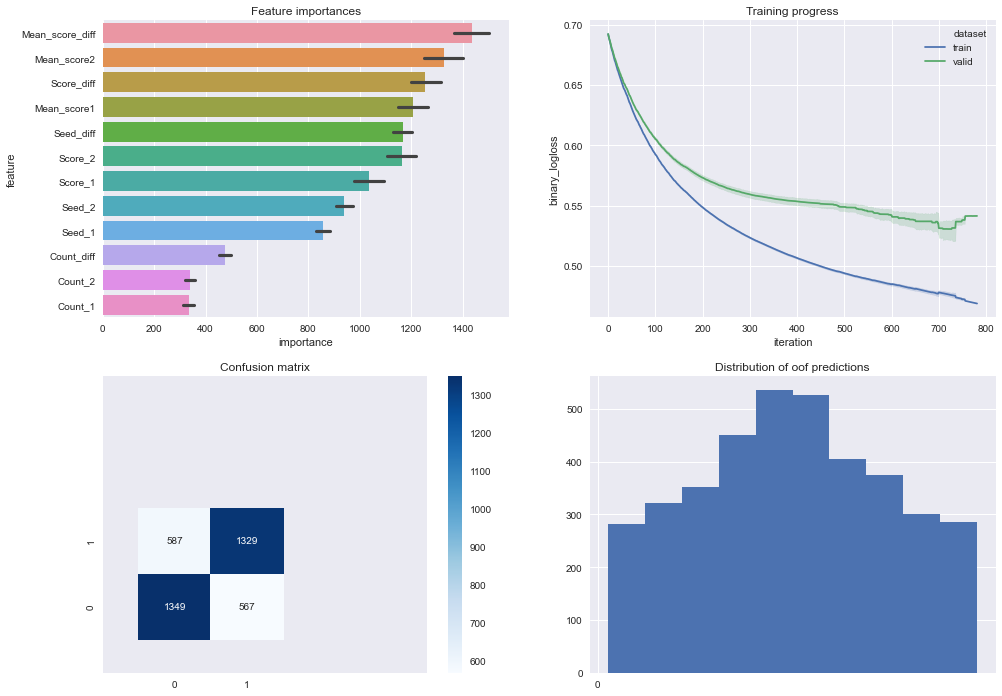

In [21]:
# some of params are from this kernel: https://www.kaggle.com/ratan123/march-madness-2020-ncaam-simple-lightgbm-on-kfold

param = {'n_estimators':10000,
          'num_leaves': 400,
          'min_child_weight': 0.034,
          'feature_fraction': 0.379,
          'bagging_fraction': 0.418,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.007,
          "boosting_type": "gbdt",
          #"bagging_seed": 11,
          "metric": 'binary_logloss',
          "verbosity": 10,
          'reg_alpha': 0.3899,
          'reg_lambda': 0.648,
          'random_state': 47,
          'task':'train', 'nthread':-1,
         'verbose': 100,
         'early_stopping_rounds': 30,
         'eval_metric': 'binary_logloss'
         }

cat_cols = []
mt = MainTransformer(create_interactions=False)

# ct = CategoricalTransformer(drop_original=True, cat_cols=cat_cols)
ft = FeatureTransformer()
transformers = {'ft': ft}

lgb_model = ClassifierModel(model_wrapper=LGBWrapper())
lgb_model.fit(X=X, y=y, folds=folds, params=param, preprocesser=mt, transformers=transformers,
                    eval_metric='binary_logloss', cols_to_drop=None, plot=True)

### Preparing test data

In [22]:
test = pd.read_csv('/Users/nicolasrousseau/pycharm_projects/ncaam-2020/ncaam/resources/data/MSampleSubmissionStage1_2020.csv')

test = test.drop(['Pred'], axis=1)
test['Season'] = test['ID'].apply(lambda x: int(x.split('_')[0]))
test['Team1'] = test['ID'].apply(lambda x: int(x.split('_')[1]))
test['Team2'] = test['ID'].apply(lambda x: int(x.split('_')[2]))

test = pd.merge(test, MNCAATourneySeeds, how='left', left_on=['Season', 'Team1'], right_on=['Season', 'TeamID'])
test = pd.merge(test, MNCAATourneySeeds, how='left', left_on=['Season', 'Team2'], right_on=['Season', 'TeamID'])
test = pd.merge(test, team_win_score, how='left', left_on=['Season', 'Team1'], right_on=['Season', 'WTeamID'])
test = pd.merge(test, team_loss_score, how='left', left_on=['Season', 'Team2'], right_on=['Season', 'LTeamID'])
test = pd.merge(test, team_loss_score, how='left', left_on=['Season', 'Team1'], right_on=['Season', 'LTeamID'])
test = pd.merge(test, team_win_score, how='left', left_on=['Season', 'Team2'], right_on=['Season', 'WTeamID'])

test['seed_diff'] = test['Seed_x'] - test['Seed_y']

In [23]:
test['x_score'] = test['WScore_sum_x'] + test['LScore_sum_y']
test['y_score'] = test['WScore_sum_y'] + test['LScore_sum_x']
test['x_count'] = test['WScore_count_x'] + test['LScore_count_y']
test['y_count'] = test['WScore_count_y'] + test['WScore_count_x']

In [24]:
test.head()

,ID,Season,Team1,Team2,TeamID_x,Seed_x,TeamID_y,Seed_y,WTeamID_x,WScore_sum_x,WScore_count_x,LTeamID_x,LScore_sum_x,LScore_count_x,LTeamID_y,LScore_sum_y,LScore_count_y,WTeamID_y,WScore_sum_y,WScore_count_y,seed_diff,x_score,y_score,x_count,y_count
0,2015_1107_1112,2015,1107,1112,NaN,NaN,NaN,NaN,1107,1627,24,1112.0,201.0,3.0,1107.0,469.0,8.0,1112,2398,31,NaN,2096.0,2599.0,32.0,55
1,2015_1107_1116,2015,1107,1116,NaN,NaN,NaN,NaN,1107,1627,24,1116.0,557.0,8.0,1107.0,469.0,8.0,1116,2096,26,NaN,2096.0,2653.0,32.0,50
2,2015_1107_1124,2015,1107,1124,NaN,NaN,NaN,NaN,1107,1627,24,1124.0,526.0,9.0,1107.0,469.0,8.0,1124,1686,23,NaN,2096.0,2212.0,32.0,47
3,2015_1107_1125,2015,1107,1125,NaN,NaN,NaN,NaN,1107,1627,24,1125.0,670.0,10.0,1107.0,469.0,8.0,1125,1617,21,NaN,2096.0,2287.0,32.0,45
4,2015_1107_1129,2015,1107,1129,NaN,NaN,NaN,NaN,1107,1627,24,1129.0,463.0,8.0,1107.0,469.0,8.0,1129,1703,23,NaN,2096.0,2166.0,32.0,47


In [25]:
test = test[['Seed_x', 'Seed_y', 'x_score', 'y_score', 'x_count', 'y_count']]
test.columns = ['Seed_1', 'Seed_2', 'Score_1', 'Score_2', 'Count_1', 'Count_2']

In [26]:
test['Seed_diff'] = test['Seed_1'] - test['Seed_2']
test['Score_diff'] = test['Score_1'] - test['Score_2']
test['Seed_diff'] = test['Seed_1'] - test['Seed_2']
test['Score_diff'] = test['Score_1'] - test['Score_2']

test['Count_diff'] = test['Count_1'] - test['Count_2']
test['Mean_score1'] = test['Score_1'] / test['Count_1']
test['Mean_score2'] = test['Score_2'] / test['Count_2']
test['Mean_score_diff'] = test['Mean_score1'] - test['Mean_score2']
test['Count_diff'] = test['Count_1'] - test['Count_2']
test['Mean_score1'] = test['Score_1'] / test['Count_1']
test['Mean_score2'] = test['Score_2'] / test['Count_2']
test['Mean_score_diff'] = test['Mean_score1'] - test['Mean_score2']

In [27]:
test.head()

,Seed_1,Seed_2,Score_1,Score_2,Count_1,Count_2,Seed_diff,Score_diff,Count_diff,Mean_score1,Mean_score2,Mean_score_diff
0,NaN,NaN,2096.0,2599.0,32.0,55,NaN,-503.0,-23.0,65.5,47.254545,18.245455
1,NaN,NaN,2096.0,2653.0,32.0,50,NaN,-557.0,-18.0,65.5,53.060000,12.440000
2,NaN,NaN,2096.0,2212.0,32.0,47,NaN,-116.0,-15.0,65.5,47.063830,18.436170
3,NaN,NaN,2096.0,2287.0,32.0,45,NaN,-191.0,-13.0,65.5,50.822222,14.677778
4,NaN,NaN,2096.0,2166.0,32.0,47,NaN,-70.0,-15.0,65.5,46.085106,19.414894


### Making predictions

In [28]:
test_preds = lgb_model.predict(test)

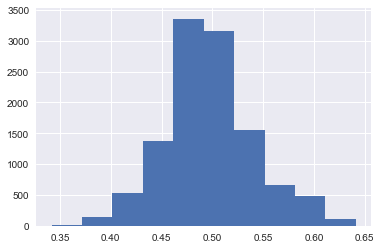

In [29]:
plt.hist(test_preds);

In [30]:
submission_df = pd.read_csv('/Users/nicolasrousseau/pycharm_projects/ncaam-2020/ncaam/resources/data/MSampleSubmissionStage1_2020.csv')
submission_df['Pred'] = test_preds
submission_df

,ID,Pred
0,2015_1107_1112,0.396619
1,2015_1107_1116,0.399733
2,2015_1107_1124,0.475544
3,2015_1107_1125,0.473956
4,2015_1107_1129,0.468790
...,...,...
11385,2019_1449_1459,0.458908
11386,2019_1449_1463,0.521536
11387,2019_1458_1459,0.476037
11388,2019_1458_1463,0.507407
